## ### Logistic Regression Model with Imbalanced Pipeline: Use imbalanced pipeline with undersampling and SMOTE (Synthetic Minority Over-sampling Technique) to address class imbalance.
The logistic regression model is trained on the resampled data.

In [114]:
# Import the required modules
import pandas as pd
import numpy as np
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE


# ##### Data Manipulation 

In [115]:
# Read the train.csv file from the Resources folder into a Pandas DataFrame
GeneticDisorder_df = pd.read_csv(
    Path("..") / "Resources" / "train.csv"
)

# Review the DataFrame
display(GeneticDisorder_df.head())
display(GeneticDisorder_df.tail())

,Patient Id,Patient Age,Genes in mother's side,Inherited from father,Maternal gene,Paternal gene,Blood cell count (mcL),Patient First Name,Family Name,Father's name,...,Birth defects,White Blood cell count (thousand per microliter),Blood test result,Symptom 1,Symptom 2,Symptom 3,Symptom 4,Symptom 5,Genetic Disorder,Disorder Subclass
0,PID0x6418,2.0,Yes,No,Yes,No,4.760603,Richard,NaN,Larre,...,NaN,9.857562,NaN,1.0,1.0,1.0,1.0,1.0,Mitochondrial genetic inheritance disorders,Leber's hereditary optic neuropathy
1,PID0x25d5,4.0,Yes,Yes,No,No,4.910669,Mike,NaN,Brycen,...,Multiple,5.522560,normal,1.0,NaN,1.0,1.0,0.0,NaN,Cystic fibrosis
2,PID0x4a82,6.0,Yes,No,No,No,4.893297,Kimberly,NaN,Nashon,...,Singular,NaN,normal,0.0,1.0,1.0,1.0,1.0,Multifactorial genetic inheritance disorders,Diabetes
3,PID0x4ac8,12.0,Yes,No,Yes,No,4.705280,Jeffery,Hoelscher,Aayaan,...,Singular,7.919321,inconclusive,0.0,0.0,1.0,0.0,0.0,Mitochondrial genetic inheritance disorders,Leigh syndrome
4,PID0x1bf7,11.0,Yes,No,NaN,Yes,4.720703,Johanna,Stutzman,Suave,...,Multiple,4.098210,NaN,0.0,0.0,0.0,0.0,NaN,Multifactorial genetic inheritance disorders,Cancer


,Patient Id,Patient Age,Genes in mother's side,Inherited from father,Maternal gene,Paternal gene,Blood cell count (mcL),Patient First Name,Family Name,Father's name,...,Birth defects,White Blood cell count (thousand per microliter),Blood test result,Symptom 1,Symptom 2,Symptom 3,Symptom 4,Symptom 5,Genetic Disorder,Disorder Subclass
22078,PID0x5598,4.0,Yes,Yes,Yes,No,5.258298,Lynn,NaN,Alhassane,...,Multiple,6.584811,inconclusive,0.0,0.0,1.0,0.0,0.0,Mitochondrial genetic inheritance disorders,Leigh syndrome
22079,PID0x19cb,8.0,No,Yes,No,Yes,4.974220,Matthew,Farley,Dartanion,...,Multiple,7.041556,inconclusive,1.0,1.0,1.0,1.0,0.0,Multifactorial genetic inheritance disorders,Diabetes
22080,PID0x3c4f,8.0,Yes,No,Yes,No,5.186470,John,NaN,Cavani,...,Singular,7.715464,normal,0.0,0.0,0.0,1.0,NaN,Mitochondrial genetic inheritance disorders,Mitochondrial myopathy
22081,PID0x13a,7.0,Yes,No,Yes,Yes,4.858543,Sharon,NaN,Bomer,...,Multiple,8.437670,abnormal,1.0,1.0,1.0,0.0,0.0,NaN,Leigh syndrome
22082,PID0x9332,11.0,Yes,No,No,No,4.738067,Andrew,Mose,Eban,...,Singular,11.188371,normal,1.0,0.0,1.0,1.0,1.0,Multifactorial genetic inheritance disorders,Diabetes


In [116]:
# Get column names and data
GeneticDisorder_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22083 entries, 0 to 22082
Data columns (total 45 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Patient Id                                        22083 non-null  object 
 1   Patient Age                                       20656 non-null  float64
 2   Genes in mother's side                            22083 non-null  object 
 3   Inherited from father                             21777 non-null  object 
 4   Maternal gene                                     19273 non-null  object 
 5   Paternal gene                                     22083 non-null  object 
 6   Blood cell count (mcL)                            22083 non-null  float64
 7   Patient First Name                                22083 non-null  object 
 8   Family Name                                       12392 non-null  object 
 9   Father's name    

In [117]:
# Replace 'Not applicable' with 'No' in the entire DataFrame
# Replace specified values with 'No' in all columns
GeneticDisorder_df.replace(['-', 'Not Available', 'No record', 'None', 'Not Applicable', 'Not applicable'], 'No', inplace=True)

In [118]:
# Assuming that no data entries in the Genetic Disorder & Disorder Subclass represent no genetic disorder present in the patient
GeneticDisorder_df['Genetic Disorder'].fillna('Not Present', inplace=True)
GeneticDisorder_df['Disorder Subclass'].fillna('Not Present', inplace=True)


In [119]:
# Replace 'Genetic Disorder' column blanks based on 'Disorder subclass' column values

# Create a mapping dictionary for each condition
condition_mapping = {
    'Cystic Fibrosis': 'Single-gene inheritance diseases',
    'Tay-Sachs': 'Single-gene inheritance diseases',
    'Hemochromatosis': 'Single-gene inheritance diseases',
    'Diabetes': 'Multifactorial genetic inheritance disorders',
    'Cancer': 'Multifactorial genetic inheritance disorders',
    "Alzheimer's": 'Multifactorial genetic inheritance disorders',
    "Leber's hereditary optic neuropathy": 'Mitochondrial genetic inheritance disorders',
    'Leigh syndrome': 'Mitochondrial genetic inheritance disorders',
    'Mitochondrial myopathy': 'Mitochondrial genetic inheritance disorders'
}

# Replace blanks in 'Genetic Disorder' column based on conditions
GeneticDisorder_df['Genetic Disorder'] = GeneticDisorder_df.apply(lambda row: condition_mapping.get(row['Disorder Subclass'], row['Genetic Disorder']), axis=1)

In [120]:
# create a new column named 'GeneticDisorder_Present' based on certain conditions.If the 'Genetic Disorder' is in the list of specific categories, the value in the new column is set to 'Yes';
# otherwise, it is set to 'No'.
GeneticDisorder_df['GeneticDisorder_Present'] = np.where(
    GeneticDisorder_df['Genetic Disorder'].isin(['Single-gene inheritance diseases', 'Multifactorial genetic inheritance disorders', 'Mitochondrial genetic inheritance disorders']),
    'Yes',
    'No'
)

In [121]:
# Drop unnecessary columns from the dataset
columns_to_remove = ['Patient Id', 'Patient First Name', 'Family Name', 'Father\'s name', 'Mother\'s age', 'Father\'s age', 'Institute Name', 'Location of Institute', 'Test 1', 'Test 2', 'Test 3', 'Test 4', 'Test 5', 'Symptom 1', 'Symptom 2', 'Symptom 3', 'Symptom 4', 'Symptom 5', 'Parental consent', 'Genetic Disorder', 'Disorder Subclass']
GeneticDisorder_cleaned_df = GeneticDisorder_df.drop(columns=columns_to_remove)

In [122]:
# Count the number of NaN values in each column
nan_counts = GeneticDisorder_cleaned_df.isna().sum()

# Display the results
print("Number of NaN values in each column:")
print(nan_counts)

Number of NaN values in each column:
Patient Age                                         1427
Genes in mother's side                                 0
Inherited from father                                306
Maternal gene                                       2810
Paternal gene                                          0
Blood cell count (mcL)                                 0
Status                                                 0
Respiratory Rate (breaths/min)                      2149
Heart Rate (rates/min                               2113
Follow-up                                           2166
Gender                                              2173
Birth asphyxia                                      2139
Autopsy shows birth defect (if applicable)          4392
Place of birth                                      2124
Folic acid details (peri-conceptional)              2117
H/O serious maternal illness                        2152
H/O radiation exposure (x-ray)                     

In [123]:
# Drop rows with missing values
GeneticDisorder_dropped_df = GeneticDisorder_cleaned_df.dropna()

In [124]:
# Confirm no NaN values are reflected
nan_counts_after_drop = GeneticDisorder_dropped_df.isna().sum()
print("\nNumber of NaN values in each column after dropping rows:")
print(nan_counts_after_drop)


Number of NaN values in each column after dropping rows:
Patient Age                                         0
Genes in mother's side                              0
Inherited from father                               0
Maternal gene                                       0
Paternal gene                                       0
Blood cell count (mcL)                              0
Status                                              0
Respiratory Rate (breaths/min)                      0
Heart Rate (rates/min                               0
Follow-up                                           0
Gender                                              0
Birth asphyxia                                      0
Autopsy shows birth defect (if applicable)          0
Place of birth                                      0
Folic acid details (peri-conceptional)              0
H/O serious maternal illness                        0
H/O radiation exposure (x-ray)                      0
H/O substance abuse     

In [125]:
# Confirm that are no duplicate rows
duplicate_count = GeneticDisorder_dropped_df.duplicated().sum()

print("Count of duplicate rows:", duplicate_count)

# X_train_no_duplicates = GeneticDisorder_dropped_df.drop_duplicates()

Count of duplicate rows: 0


In [126]:
# Display the cleaned DataFrame
display(GeneticDisorder_dropped_df.head())
display(GeneticDisorder_dropped_df.tail())

,Patient Age,Genes in mother's side,Inherited from father,Maternal gene,Paternal gene,Blood cell count (mcL),Status,Respiratory Rate (breaths/min),Heart Rate (rates/min,Follow-up,...,H/O serious maternal illness,H/O radiation exposure (x-ray),H/O substance abuse,Assisted conception IVF/ART,History of anomalies in previous pregnancies,No. of previous abortion,Birth defects,White Blood cell count (thousand per microliter),Blood test result,GeneticDisorder_Present
8,11.0,No,No,Yes,No,5.209058,Alive,Tachypnea,Tachycardia,Low,...,Yes,No,No,No,Yes,0.0,Multiple,6.669552,slightly abnormal,Yes
9,4.0,No,Yes,Yes,Yes,4.752272,Alive,Tachypnea,Tachycardia,Low,...,No,No,No,Yes,Yes,1.0,Multiple,6.397702,abnormal,Yes
14,6.0,Yes,No,Yes,No,4.620420,Alive,Tachypnea,Tachycardia,High,...,Yes,Yes,No,No,No,3.0,Multiple,3.000000,slightly abnormal,Yes
18,10.0,Yes,Yes,Yes,No,4.751452,Deceased,Normal (30-60),Tachycardia,Low,...,No,Yes,No,Yes,Yes,3.0,Singular,9.382407,abnormal,Yes
19,6.0,No,Yes,Yes,Yes,4.876896,Deceased,Tachypnea,Normal,Low,...,Yes,No,No,Yes,No,1.0,Singular,7.370477,normal,Yes


,Patient Age,Genes in mother's side,Inherited from father,Maternal gene,Paternal gene,Blood cell count (mcL),Status,Respiratory Rate (breaths/min),Heart Rate (rates/min,Follow-up,...,H/O serious maternal illness,H/O radiation exposure (x-ray),H/O substance abuse,Assisted conception IVF/ART,History of anomalies in previous pregnancies,No. of previous abortion,Birth defects,White Blood cell count (thousand per microliter),Blood test result,GeneticDisorder_Present
22066,13.0,No,Yes,No,Yes,4.777036,Alive,Normal (30-60),Normal,High,...,Yes,No,No,No,Yes,1.0,Singular,3.000736,normal,Yes
22068,4.0,Yes,No,No,No,5.077554,Deceased,Normal (30-60),Normal,Low,...,Yes,No,No,No,No,1.0,Singular,9.566549,inconclusive,Yes
22076,0.0,Yes,No,Yes,No,4.931758,Alive,Normal (30-60),Tachycardia,Low,...,No,No,No,Yes,Yes,1.0,Singular,11.649052,abnormal,Yes
22079,8.0,No,Yes,No,Yes,4.974220,Alive,Normal (30-60),Normal,High,...,Yes,No,No,Yes,No,2.0,Multiple,7.041556,inconclusive,Yes
22081,7.0,Yes,No,Yes,Yes,4.858543,Alive,Tachypnea,Tachycardia,High,...,Yes,No,Yes,Yes,No,1.0,Multiple,8.437670,abnormal,Yes


In [127]:
# Export cleaned CSV data
# GeneticDisorder_dropped_df.to_csv('Resources/GeneticDisorder_cleaned_AllFeatures.csv', index=False)

In [128]:
# Identify and encode categorical columns
categorical_columns = GeneticDisorder_dropped_df.select_dtypes(include=['object']).columns
GeneticDisorder_encoded_df = pd.get_dummies(GeneticDisorder_dropped_df, columns=categorical_columns, drop_first=True)


In [129]:
# Obtain the 'Genetic Disorder' names in the columns
print(GeneticDisorder_encoded_df.columns)

Index(['Patient Age', 'Blood cell count (mcL)', 'No. of previous abortion',
       'White Blood cell count (thousand per microliter)',
       'Genes in mother's side_Yes', 'Inherited from father_Yes',
       'Maternal gene_Yes', 'Paternal gene_Yes', 'Status_Deceased',
       'Respiratory Rate (breaths/min)_Tachypnea',
       'Heart Rate (rates/min_Tachycardia', 'Follow-up_Low', 'Gender_Female',
       'Gender_Male', 'Birth asphyxia_Not available', 'Birth asphyxia_Yes',
       'Autopsy shows birth defect (if applicable)_Yes',
       'Place of birth_Institute',
       'Folic acid details (peri-conceptional)_Yes',
       'H/O serious maternal illness_Yes',
       'H/O radiation exposure (x-ray)_Yes', 'H/O substance abuse_Yes',
       'Assisted conception IVF/ART_Yes',
       'History of anomalies in previous pregnancies_Yes',
       'Birth defects_Singular', 'Blood test result_inconclusive',
       'Blood test result_normal', 'Blood test result_slightly abnormal',
       'GeneticDisorder_

In [130]:
# Create a binary target column indicating the presence (1) or absence (0) of a genetic disorder
GeneticDisorder_encoded_df['Genetic Disorder Present'] = np.where(
    GeneticDisorder_encoded_df['GeneticDisorder_Present_Yes'] == 1,
    'Yes',
    'No'
)

# Drop the original columns used for creating the binary target column
GeneticDisorder_encoded_df.drop(['GeneticDisorder_Present_Yes'], axis=1, inplace=True)



In [131]:
# Using all columns as features for training
X = GeneticDisorder_encoded_df.drop(['Genetic Disorder Present'], axis=1)  # Exclude the target column
y = GeneticDisorder_encoded_df['Genetic Disorder Present']


In [132]:
# Remove everything after the underscore for all columns
# GeneticDisorder_encoded_df.columns = GeneticDisorder_encoded_df.columns.str.split('_').str.get(0)

In [133]:
# View the updated dataset
GeneticDisorder_encoded_df

,Patient Age,Blood cell count (mcL),No. of previous abortion,White Blood cell count (thousand per microliter),Genes in mother's side_Yes,Inherited from father_Yes,Maternal gene_Yes,Paternal gene_Yes,Status_Deceased,Respiratory Rate (breaths/min)_Tachypnea,...,H/O serious maternal illness_Yes,H/O radiation exposure (x-ray)_Yes,H/O substance abuse_Yes,Assisted conception IVF/ART_Yes,History of anomalies in previous pregnancies_Yes,Birth defects_Singular,Blood test result_inconclusive,Blood test result_normal,Blood test result_slightly abnormal,Genetic Disorder Present
8,11.0,5.209058,0.0,6.669552,False,False,True,False,False,True,...,True,False,False,False,True,False,False,False,True,Yes
9,4.0,4.752272,1.0,6.397702,False,True,True,True,False,True,...,False,False,False,True,True,False,False,False,False,Yes
14,6.0,4.620420,3.0,3.000000,True,False,True,False,False,True,...,True,True,False,False,False,False,False,False,True,Yes
18,10.0,4.751452,3.0,9.382407,True,True,True,False,True,False,...,False,True,False,True,True,True,False,False,False,Yes
19,6.0,4.876896,1.0,7.370477,False,True,True,True,True,True,...,True,False,False,True,False,True,False,True,False,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22066,13.0,4.777036,1.0,3.000736,False,True,False,True,False,False,...,True,False,False,False,True,True,False,True,False,Yes
22068,4.0,5.077554,1.0,9.566549,True,False,False,False,True,False,...,True,False,False,False,False,True,True,False,False,Yes
22076,0.0,4.931758,1.0,11.649052,True,False,True,False,False,False,...,False,False,False,True,True,True,False,False,False,Yes
22079,8.0,4.974220,2.0,7.041556,False,True,False,True,False,False,...,True,False,False,True,False,False,True,False,False,Yes


In [134]:
# Export GeneticDisorder_encoded_df to CSV file
# GeneticDisorder_encoded_df.to_csv('../Resources/GeneticDisorder_encoded_AllFeatures.csv', index=False)

c:\Users\starl\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\starl\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\starl\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


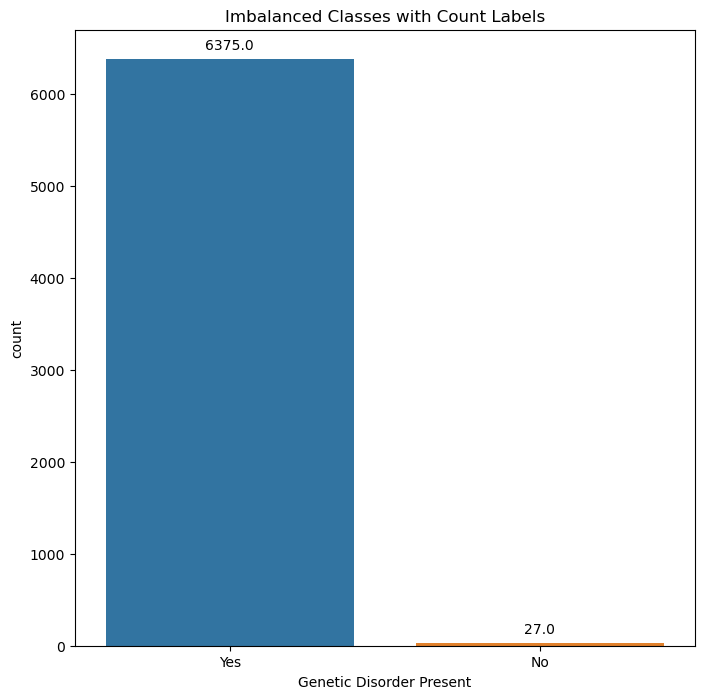

In [135]:
#plot the dataset class imbalance
plt.figure(figsize=(8, 8))
ax = sns.countplot(x='Genetic Disorder Present', data=GeneticDisorder_encoded_df)

# Add count labels on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Imbalanced Classes with Count Labels')
plt.show()


# ### Logistic Regression Model

In [136]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)


In [137]:
# Check class imbalance
imbalance_ratio = len(y_train[y_train == 0]) / len(y_train[y_train == 1]) if len(y_train[y_train == 1]) != 0 else 1.0
print("Imbalance Ratio:", imbalance_ratio)



Imbalance Ratio: 1.0


In [138]:
# Create an imbalanced pipeline with undersampling and SMOTE
undersampler = RandomUnderSampler(sampling_strategy=0.2)
oversampler = SMOTE(sampling_strategy=1.0)
pipeline = Pipeline([('under', undersampler), ('over', oversampler)])

# SMOTE is an oversampling technique that works by generating synthetic samples for the minority class. It helps to balance the class distribution in a dataset, which can be useful when one class has significantly fewer samples than the other.

In [139]:
# Resample the training data
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

In [140]:
# Instantiate Logistic Regression model
logreg_model = LogisticRegression(random_state=9, max_iter=1000, solver='liblinear')


In [141]:
# Fit the Logistic Regression model
logreg_model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=1000, random_state=9, solver='liblinear')

c:\Users\starl\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\starl\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\starl\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


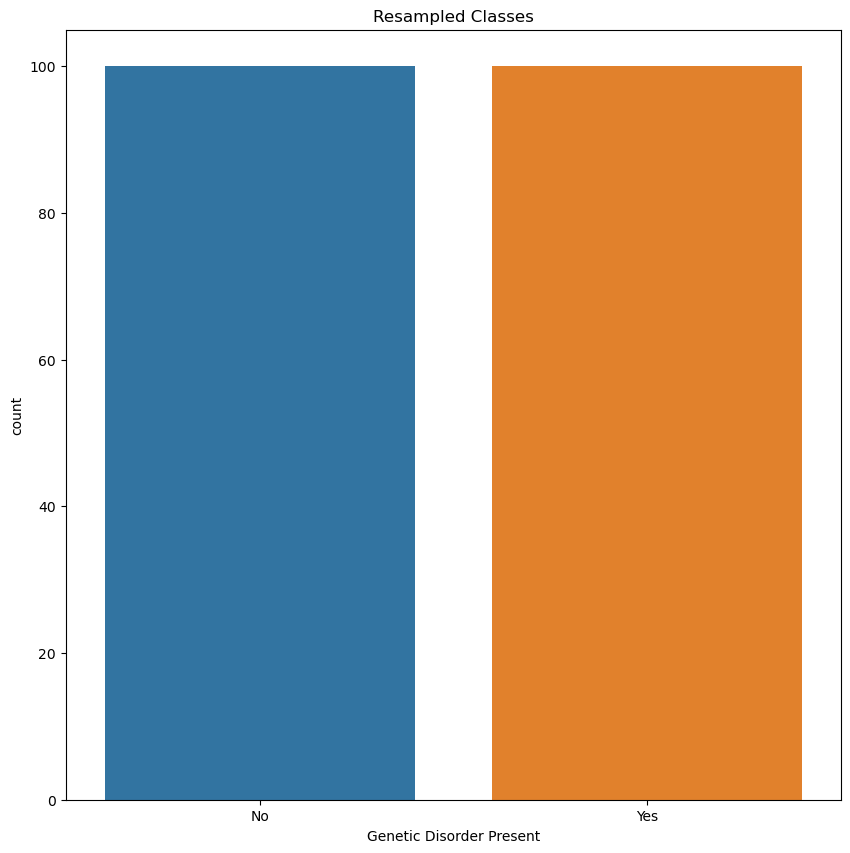

In [142]:
# Convert y_train_resampled to a DataFrame
y_train_resampled_df = pd.DataFrame({'Genetic Disorder Present': y_train_resampled})

# Plot the classes after the resampling
plt.figure(figsize=(10, 10))
sns.countplot(x='Genetic Disorder Present', data=y_train_resampled_df)
plt.title('Resampled Classes')
plt.show()

In [143]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [144]:
# Fit and save the logistic regression model using the resampled data
logreg_model.fit(X_train_scaled, y_train_resampled)

LogisticRegression(max_iter=1000, random_state=9, solver='liblinear')

In [145]:
# Use the original testing data for evaluation
X_test_resampled, y_test_resampled = X_test_scaled, y_test

In [146]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [147]:
# Fit and save the logistic regression model using the resampled data
logreg_model.fit(X_train_scaled, y_train_resampled)

LogisticRegression(max_iter=1000, random_state=9, solver='liblinear')

In [148]:
# Use the original testing data for evaluation
X_test_resampled, y_test_resampled = X_test_scaled, y_test



In [149]:
# Generate training predictions
GDtraining_predictions = logreg_model.predict(X_train_resampled)

# Generate testing predictions
GDtesting_predictions = logreg_model.predict(X_test_resampled)

c:\Users\starl\anaconda3\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [150]:
# Cross-Validation for Logistic Regression
cv_scores_lr = cross_val_score(logreg_model, X_train_scaled, y_train_resampled, cv=5)
print("Logistic Regression Cross-Validation Scores:", cv_scores_lr)
print("Mean Cross-Validation Score (LR):", cv_scores_lr.mean())

# the mean cross-validation score provides a summary measure of the model's average performance

Logistic Regression Cross-Validation Scores: [0.475 0.825 0.9   0.875 0.825]
Mean Cross-Validation Score (LR): 0.7799999999999999


In [151]:
print("Shape of y_train_resampled:", y_train_resampled.shape)
print("Shape of GDtraining_predictions:", GDtraining_predictions.shape)


Shape of y_train_resampled: (200,)
Shape of GDtraining_predictions: (200,)


In [152]:
# Display confusion matrix for the training data
GDtraining_matrix = confusion_matrix(y_train_resampled, GDtraining_predictions)
print("Confusion Matrix for Logistic Regression model (Training Data):")
print(GDtraining_matrix)

Confusion Matrix for Logistic Regression model (Training Data):
[[100   0]
 [100   0]]


In [153]:
# Display confusion matrix for the testing data
GDtesting_matrix = confusion_matrix(y_test_resampled, GDtesting_predictions)
print("Confusion Matrix for Logistic Regression model (Testing Data):")
print(GDtesting_matrix)

Confusion Matrix for Logistic Regression model (Testing Data):
[[   3    4]
 [ 390 1204]]


In [154]:
# Display classification report for the training data
GDtraining_report = classification_report(y_train_resampled, GDtraining_predictions)
print("Training Classification Report for Logistic Regression model:")
print(GDtraining_report)

Training Classification Report for Logistic Regression model:
              precision    recall  f1-score   support

          No       0.50      1.00      0.67       100
         Yes       0.00      0.00      0.00       100

    accuracy                           0.50       200
   macro avg       0.25      0.50      0.33       200
weighted avg       0.25      0.50      0.33       200



c:\Users\starl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\starl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\starl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [155]:
# Display classification report for the testing data
GDtesting_report = classification_report(y_test_resampled, GDtesting_predictions)
print("Testing Classification Report for Logistic Regression model:")
print(GDtesting_report)

Testing Classification Report for Logistic Regression model:
              precision    recall  f1-score   support

          No       0.01      0.43      0.01         7
         Yes       1.00      0.76      0.86      1594

    accuracy                           0.75      1601
   macro avg       0.50      0.59      0.44      1601
weighted avg       0.99      0.75      0.86      1601



In [156]:
# Print the balanced_accuracy score of the model
print(f"The balanced_accuracy score of the model: {balanced_accuracy_score(y_test_resampled, GDtesting_predictions)}")

The balanced_accuracy score of the model: 0.5919519627173329


Using Logistics Regression Model Predict Outcomes Using Genetic Disorder

In [157]:
# Predict outcomes for test data set using the existing logistic regression model
predictions_df = pd.DataFrame({"Prediction": GDtesting_predictions, "Actual": y_test_resampled})
print(predictions_df)

      Prediction Actual
2934         Yes    Yes
15086        Yes    Yes
10626        Yes    Yes
10950        Yes    Yes
19898        Yes    Yes
...          ...    ...
11952        Yes    Yes
21           Yes    Yes
17890        Yes    Yes
7586         Yes    Yes
8907         Yes    Yes

[1601 rows x 2 columns]


# ### Visual Representation of Logistic Regression Model

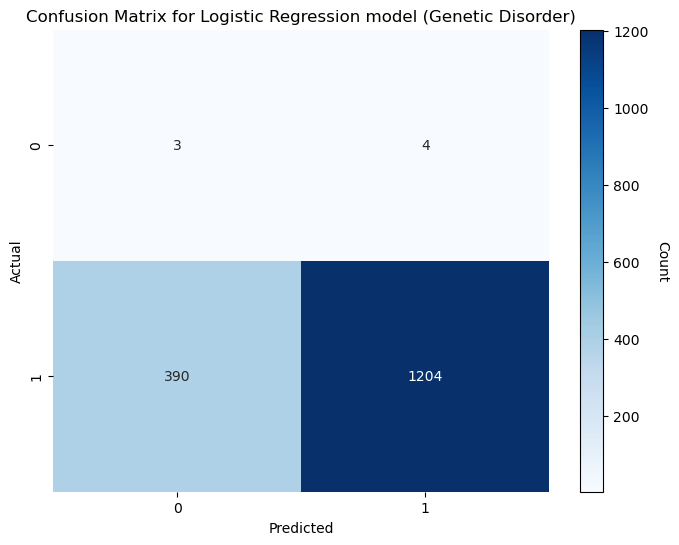

In [158]:
# Confusion Matrix Heatmap for Logistic Regression model
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(GDtesting_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Logistic Regression model (Genetic Disorder)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
cbar = heatmap.figure.colorbar(heatmap.collections[0])
cbar.set_label('Count', rotation=270, labelpad=15)
plt.show()
# The confusion matrix heatmap allows users to visually assess how well the Logistic Regression model \
# is performing in predicting the "Genetic Disorder" by comparing the predicted and actual classes. The goal is \
# to have higher counts along the diagonal (from the top left to the bottom right), indicating correct predictions, and \
# lower counts in off-diagonal cells, indicating misclassifications. The color intensity provides a quick visual summary \
# of the distribution of predictions.

# ### Feature Importance in Logistics Regression

In [159]:
# Get feature names and their coefficients
coefficient_values = logreg_model.coef_[0]
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficient_values})
feature_importance_df['Absolute Coefficient'] = feature_importance_df['Coefficient'].abs()
feature_importance_df = feature_importance_df.sort_values(by='Absolute Coefficient', ascending=False)

# Display top features and their coefficients
print("\nTop Features and Coefficients:")
print(feature_importance_df)

# Coefficients indicate the strength and direction (positive or negative) of the relationship between each feature and the predicted outcome. \
# A negative coefficient suggests an inverse relationship between the feature and the predicted outcome. As "Patient Age" and "Blood cell count (mcL)" \
# have negative coefficients, an increase in these values is associated with a decrease in the predicted outcome (lower likelihood of a Genetic Disorder).
# Magnitude (Absolute Coefficient) of the coefficient indicates the strength of the relationship. Larger absolute values indicate a stronger influence on the predicted outcome.



Top Features and Coefficients:
                                             Feature  Coefficient  \
9           Respiratory Rate (breaths/min)_Tachypnea    -1.369680   
14                      Birth asphyxia_Not available    -1.162638   
11                                     Follow-up_Low    -0.959041   
13                                       Gender_Male    -0.775762   
4                         Genes in mother's side_Yes    -0.671862   
25                    Blood test result_inconclusive    -0.617093   
3   White Blood cell count (thousand per microliter)    -0.562804   
16    Autopsy shows birth defect (if applicable)_Yes    -0.486960   
26                          Blood test result_normal    -0.474525   
0                                        Patient Age    -0.472822   
1                             Blood cell count (mcL)     0.465290   
7                                  Paternal gene_Yes    -0.442146   
21                           H/O substance abuse_Yes    -0.427040   
18

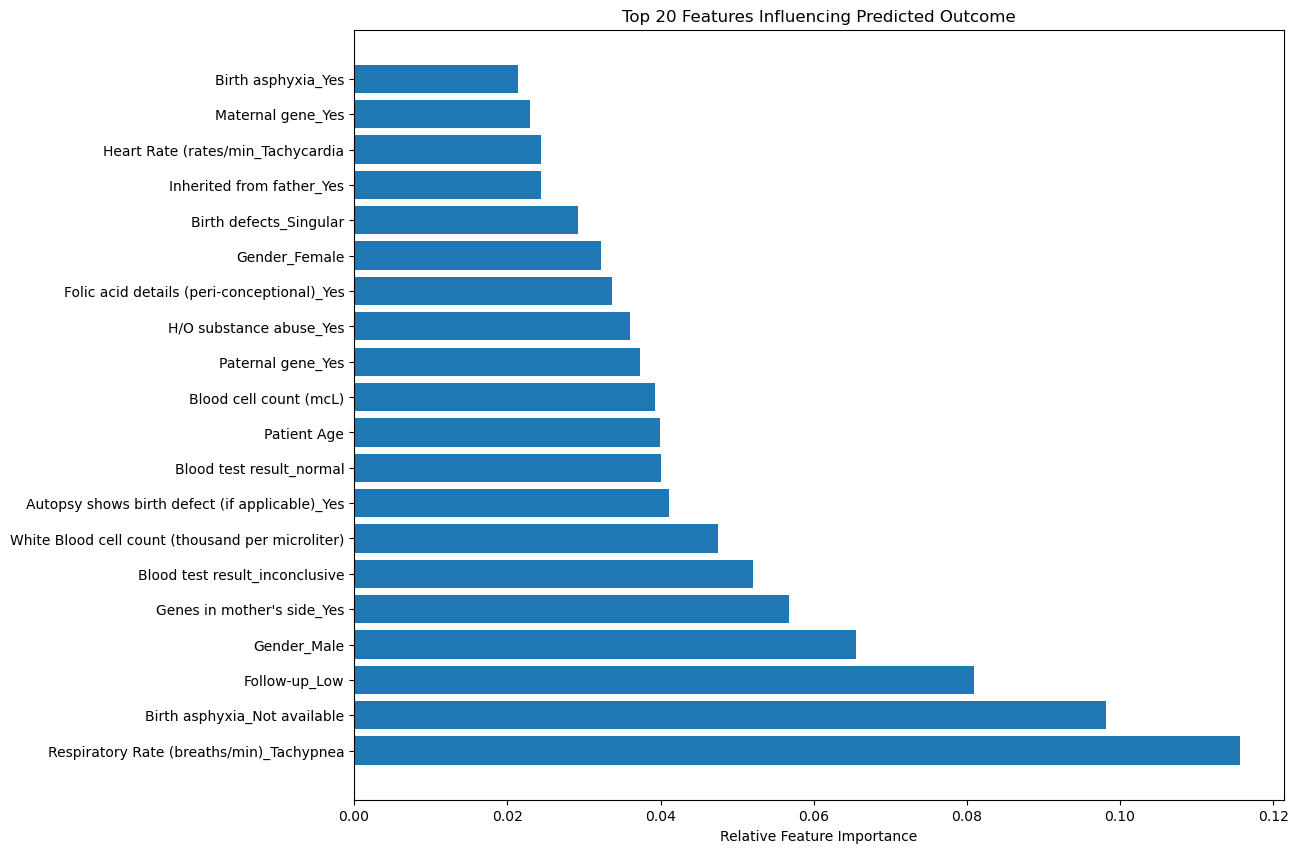

In [160]:
# Plot top 20 features and their importance
normalized_coefficients = feature_importance_df['Absolute Coefficient'] / feature_importance_df['Absolute Coefficient'].sum()
plt.figure(figsize=(12, 10))
plt.barh(feature_importance_df['Feature'][:20], normalized_coefficients[:20])
plt.xlabel('Relative Feature Importance')
plt.title('Top 20 Features Influencing Predicted Outcome')
plt.show()
# This graph helps users identify and prioritize the most influential features for the logistic regression model. \
# "Coefficient Magnitude" is a measure of how much a feature contributes to the model's predictions, considering both \
# the positive and negative impacts. Larger magnitudes indicate features that have a more substantial influence on the predicted outcome.

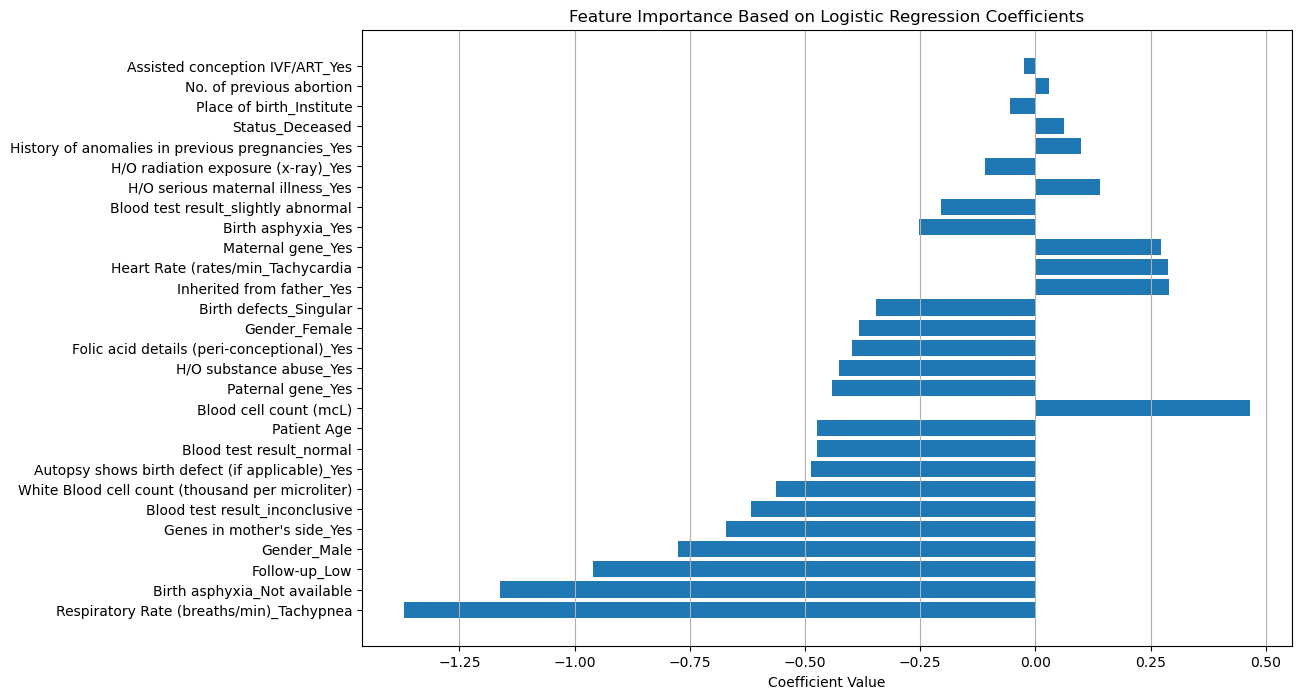

In [161]:
# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Feature Importance Based on Logistic Regression Coefficients')
plt.grid(axis='x')
plt.show()

# The graph shows the contribution of each feature to the logistic regression model's predictions \
# The length of each bar represents the magnitude of the coefficient for a specific feature. Larger magnitudes \
# (positive or negative) indicate a stronger impact on the predicted outcome.  The direction of the bar (to the right or left of the centerline) \
# indicates the direction of the impact. If the bar is to the right, it suggests a positive impact on the predicted outcome, while a bar to the left suggests a negative impact. \
# Positive coefficients suggest that an increase in the corresponding feature value makes the prediction more likely to be in class 1 ("Present" in this case), while negative coefficients suggest the opposite.

# ### Random Forest Classifier

In [162]:
# Instantiate a Random Forest classifier
random_forest_model = RandomForestClassifier(random_state=9)

In [163]:
# Fit and save the Random Forest model using the resampled data
random_forest_model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=9)

In [164]:
# Generate training predictions using Random Forest
GDtraining_predictions_rf = random_forest_model.predict(X_train_resampled)

# Generate testing predictions using Random Forest
GDtesting_predictions_rf = random_forest_model.predict(X_test_scaled)

c:\Users\starl\anaconda3\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [165]:
# Cross-Validation for Random Forest using resampled data
cv_scores_rf = cross_val_score(random_forest_model, X_train_resampled, y_train_resampled, cv=5)
print("Random Forest Cross-Validation Scores:", cv_scores_rf)
print("Mean Cross-Validation Score (RF):", cv_scores_rf.mean())

Random Forest Cross-Validation Scores: [0.7   0.95  0.95  0.95  0.925]
Mean Cross-Validation Score (RF): 0.8949999999999999


In [166]:
# Display confusion matrix for the training data with Random Forest
GDtraining_matrix_rf = confusion_matrix(y_train_resampled, GDtraining_predictions_rf)
print("Confusion Matrix for Random Forest model:")
print(GDtraining_matrix_rf)

Confusion Matrix for Random Forest model:
[[100   0]
 [  0 100]]


In [167]:
# Display confusion matrix for the testing data with Random Forest
GDtesting_matrix_rf = confusion_matrix(y_test, GDtesting_predictions_rf)
print("Confusion Matrix for Random Forest model:")
print(GDtesting_matrix_rf)

Confusion Matrix for Random Forest model:
[[   0    7]
 [  11 1583]]


In [168]:
# Create and save the confusion matrix for the testing data with Random Forest
GDtesting_matrix_rf = confusion_matrix(y_test, GDtesting_predictions_rf)
print("Confusion Matrix for Random Forest model:")
print(GDtesting_matrix_rf)

Confusion Matrix for Random Forest model:
[[   0    7]
 [  11 1583]]


In [169]:
# Display classification report for the testing data with Random Forest
GDtesting_report_rf = classification_report(y_test, GDtesting_predictions_rf)
print("Classification Report for Random Forest model:")
print(GDtesting_report_rf)

Classification Report for Random Forest model:
              precision    recall  f1-score   support

          No       0.00      0.00      0.00         7
         Yes       1.00      0.99      0.99      1594

    accuracy                           0.99      1601
   macro avg       0.50      0.50      0.50      1601
weighted avg       0.99      0.99      0.99      1601



In [170]:
# Print the balanced_accuracy score of the Random Forest model
print(f"The balanced_accuracy score of the Random Forest model: {balanced_accuracy_score(y_test, GDtesting_predictions_rf)}")



The balanced_accuracy score of the Random Forest model: 0.4965495608531995


# ### Feature Importance in Random Forest

In [171]:
# Get feature importances from Random Forest model
rf_feature_importances = random_forest_model.feature_importances_

In [172]:
# Get the names of all features
all_feature_names_rf = X.columns

In [173]:
# Get the indices of the top 20 features
top_20_indices_rf = rf_feature_importances.argsort()[-20:][::-1]

In [174]:
# Get the names and importance of the top 20 features
top_20_feature_names_rf = all_feature_names_rf[top_20_indices_rf]
top_20_feature_importance_rf = rf_feature_importances[top_20_indices_rf]


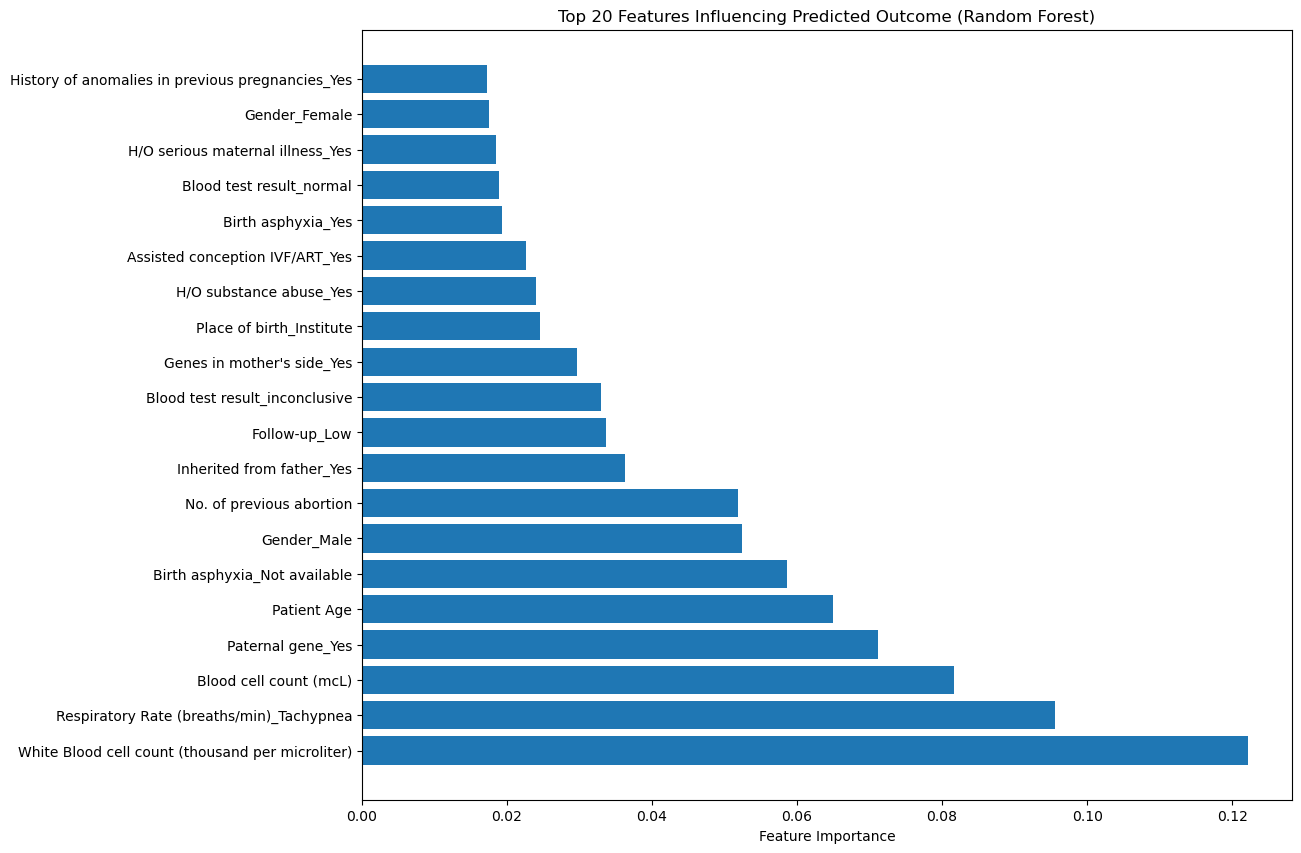

In [175]:
# Plot the top 20 features and their importance from Random Forest
plt.figure(figsize=(12, 10))
plt.barh(top_20_feature_names_rf, top_20_feature_importance_rf)
plt.xlabel('Feature Importance')
plt.title('Top 20 Features Influencing Predicted Outcome (Random Forest)')
plt.show()

# ###### Model Comparison

In [183]:
# Function to display comparison metrics for two models
def compare_models(model1_name, model1_predictions, model2_name, model2_predictions, y_true):
    print(f"Comparison of {model1_name} and {model2_name}:\n")
    
    # Balanced Accuracy
    balanced_acc_model1 = balanced_accuracy_score(y_true, model1_predictions)
    print("Mean Cross-Validation Score (Logistic Regression):", cv_scores_lr.mean())
    balanced_acc_model2 = balanced_accuracy_score(y_true, model2_predictions)
    print("Mean Cross-Validation Score (Random Forest):", cv_scores_rf.mean())
    print(f"Balanced Accuracy ({model1_name}): {balanced_acc_model1:.4f}")
    print(f"Balanced Accuracy ({model2_name}): {balanced_acc_model2:.4f}\n")
    
    # Classification Report
    print(f"Classification Report ({model1_name}):\n{classification_report(y_true, model1_predictions)}")
    print(f"Classification Report ({model2_name}):\n{classification_report(y_true, model2_predictions)}\n")
    
    # Confusion Matrix
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    sns.heatmap(confusion_matrix(y_true, model1_predictions), annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix ({model1_name})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    plt.subplot(1, 2, 2)
    sns.heatmap(confusion_matrix(y_true, model2_predictions), annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix ({model2_name})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    plt.tight_layout()
    plt.show()

c:\Users\starl\anaconda3\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Comparison of Logistic Regression and Random Forest:

Mean Cross-Validation Score (Logistic Regression): 0.7799999999999999
Mean Cross-Validation Score (Random Forest): 0.8949999999999999
Balanced Accuracy (Logistic Regression): 0.5920
Balanced Accuracy (Random Forest): 0.4965

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

          No       0.01      0.43      0.01         7
         Yes       1.00      0.76      0.86      1594

    accuracy                           0.75      1601
   macro avg       0.50      0.59      0.44      1601
weighted avg       0.99      0.75      0.86      1601

Classification Report (Random Forest):
              precision    recall  f1-score   support

          No       0.00      0.00      0.00         7
         Yes       1.00      0.99      0.99      1594

    accuracy                           0.99      1601
   macro avg       0.50      0.50      0.50      1601
weighted avg       0.99      0.99     

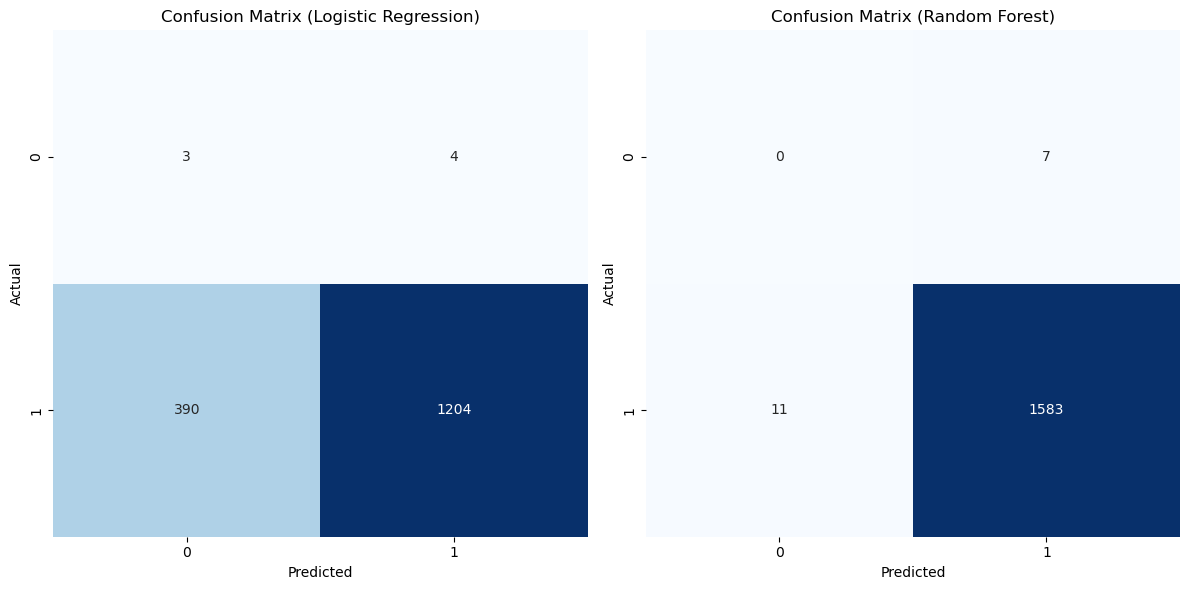

In [184]:
# Compare Logistic Regression and Random Forest
compare_models("Logistic Regression", logreg_model.predict(X_test_scaled),
               "Random Forest", random_forest_model.predict(X_test_scaled), y_test)

In terms of balanced accuracy, there is a slight difference in favor of Logistic Regression, but the overall performance is comparable. The classification reports provide additional insights into precision, recall, and F1-score for each class. Considering these results, neither model significantly outperforms the other. Further tuning or exploring other algorithms to potentially improve performance would be required.